## 範例 : (Kaggle)房價預測

## [教學目標]

以下用房價預測資料, 展示特徵篩選的作法

## [範例重點]

觀察相關係數過濾法的寫作方式(In[2], Out[2], In[4], Out[4]), 以及對線性迴歸與梯度提升機有什麼影響 (In[5]~In[8], Out[5]~Out[8])

觀察L1 嵌入法的寫作方式(In[9]~In[11], Out[9]~Out[11]), 以及對線性迴歸與梯度提升機有什麼影響 (In[12], Out[12], In[13], Out[13])

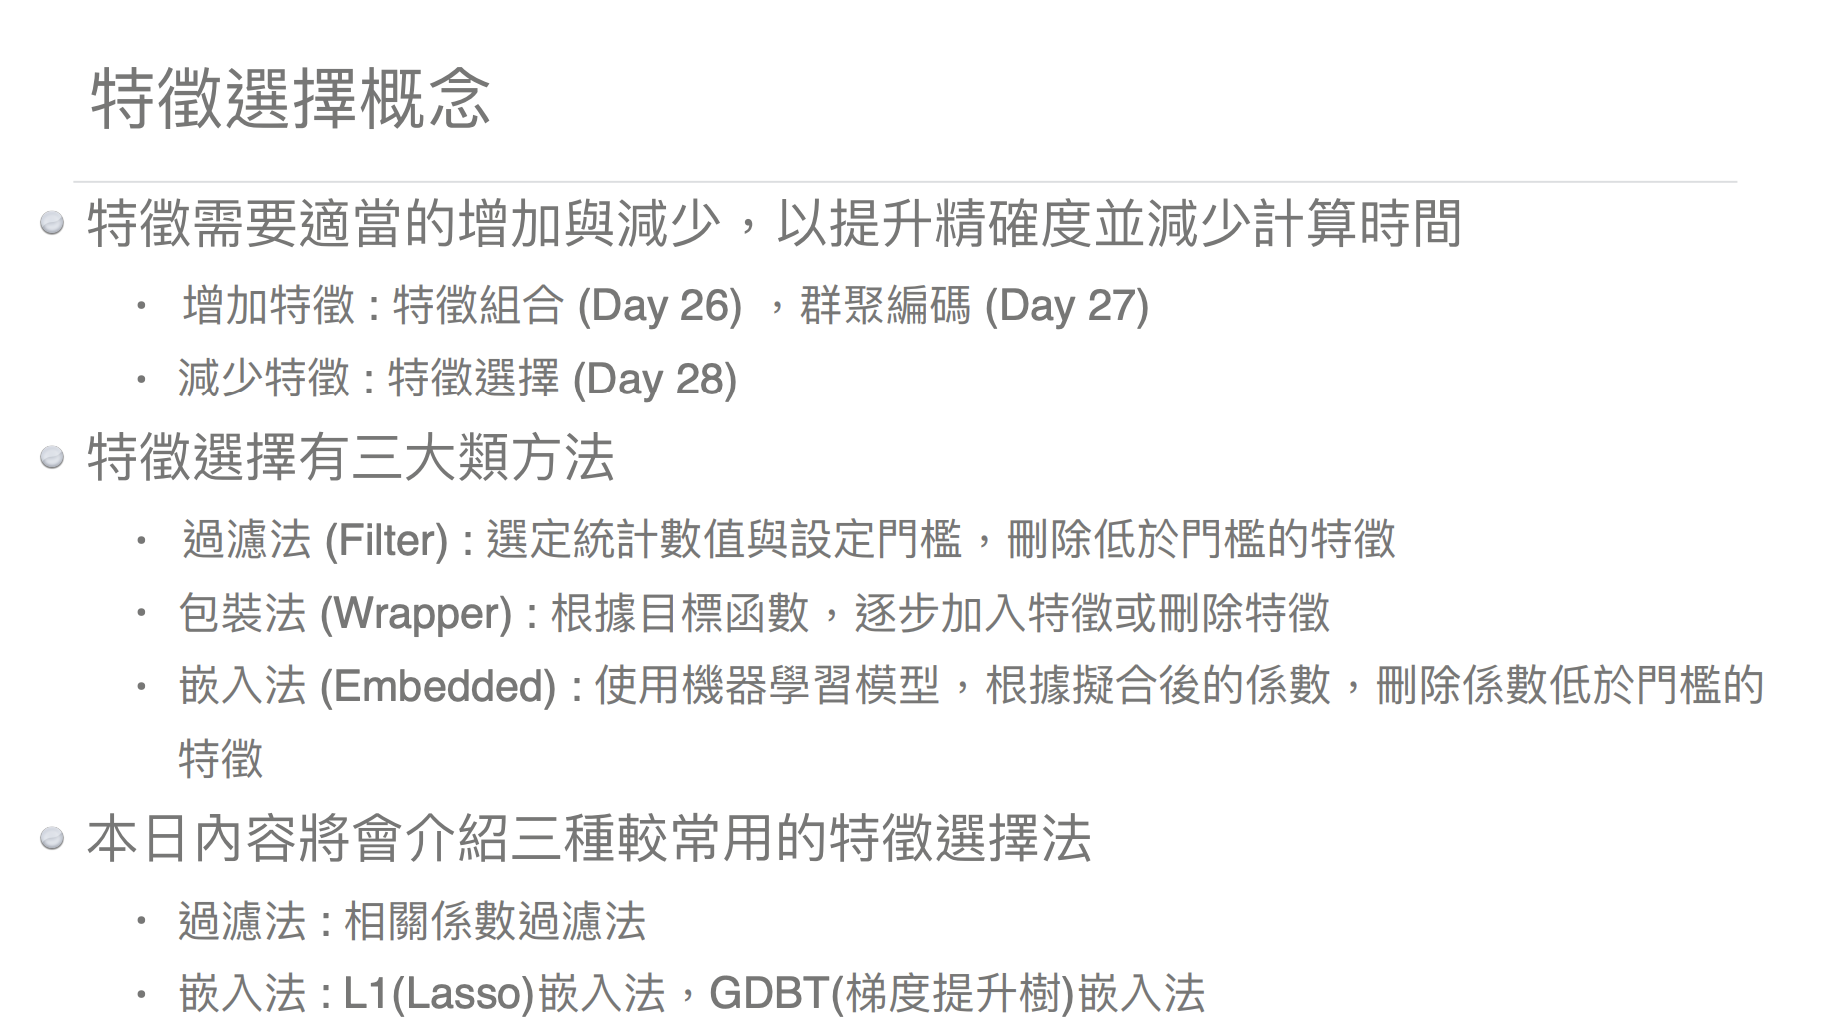

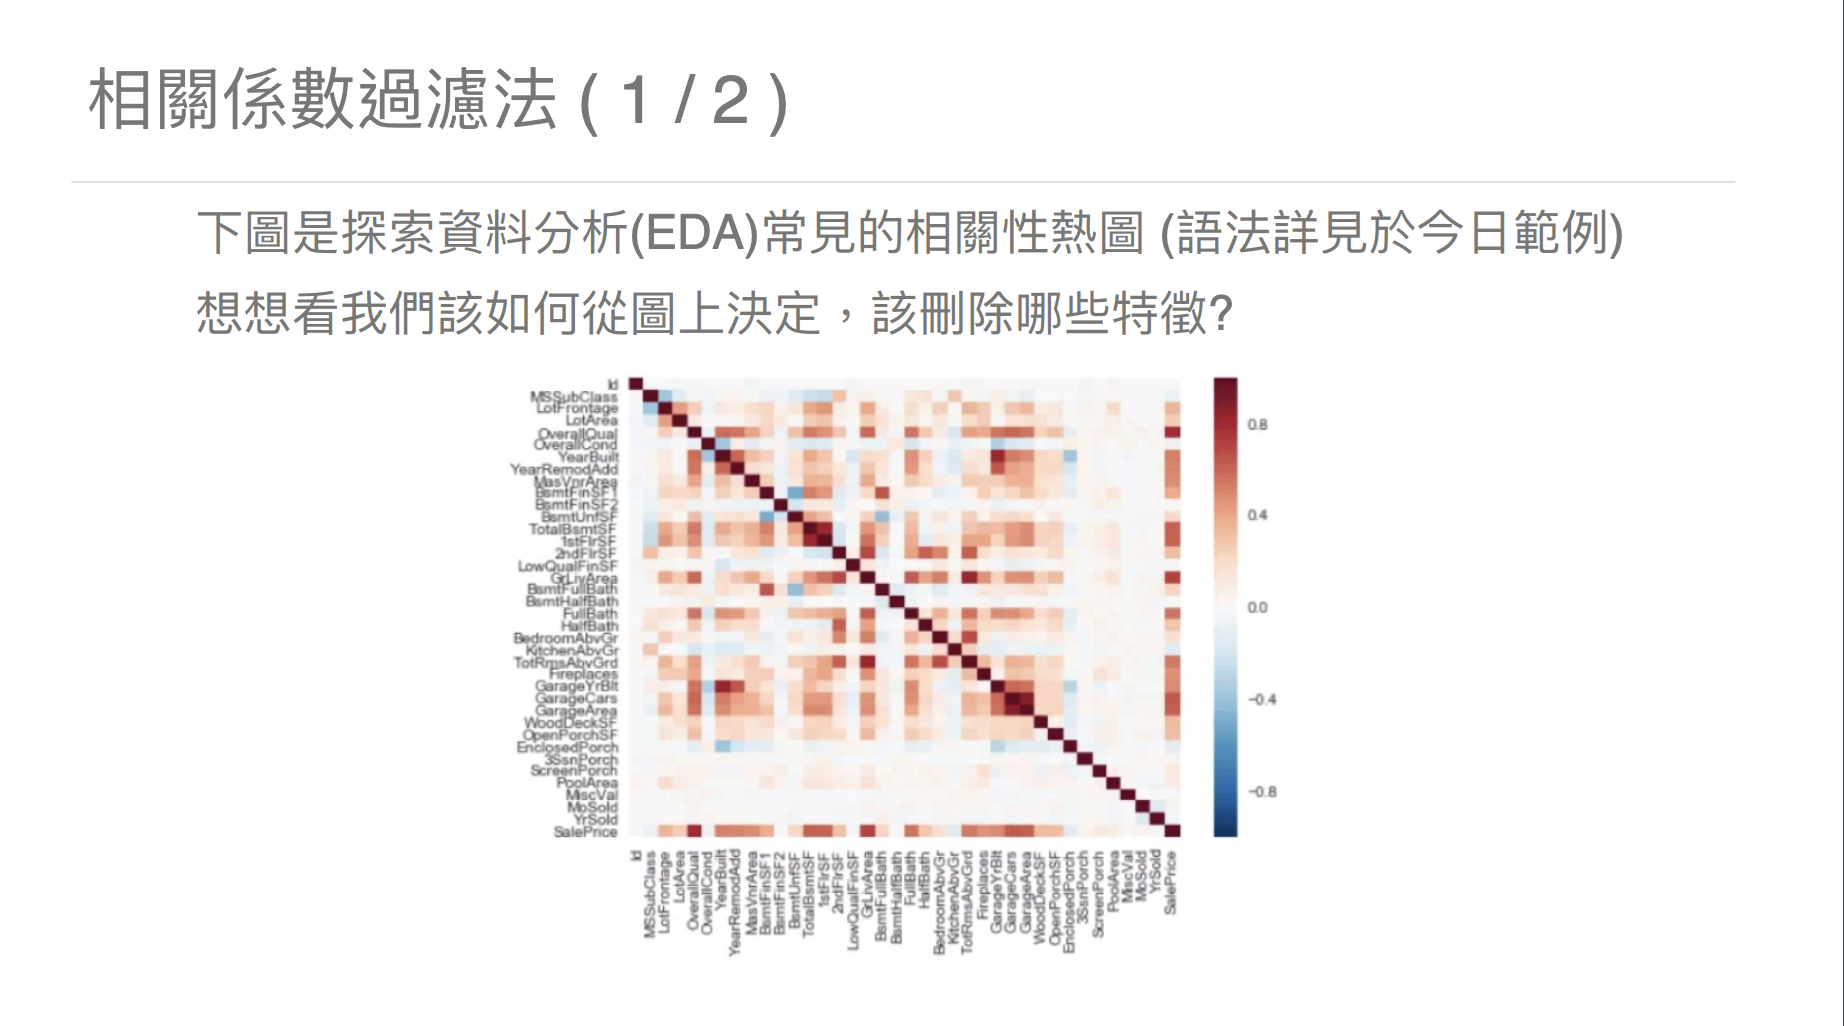

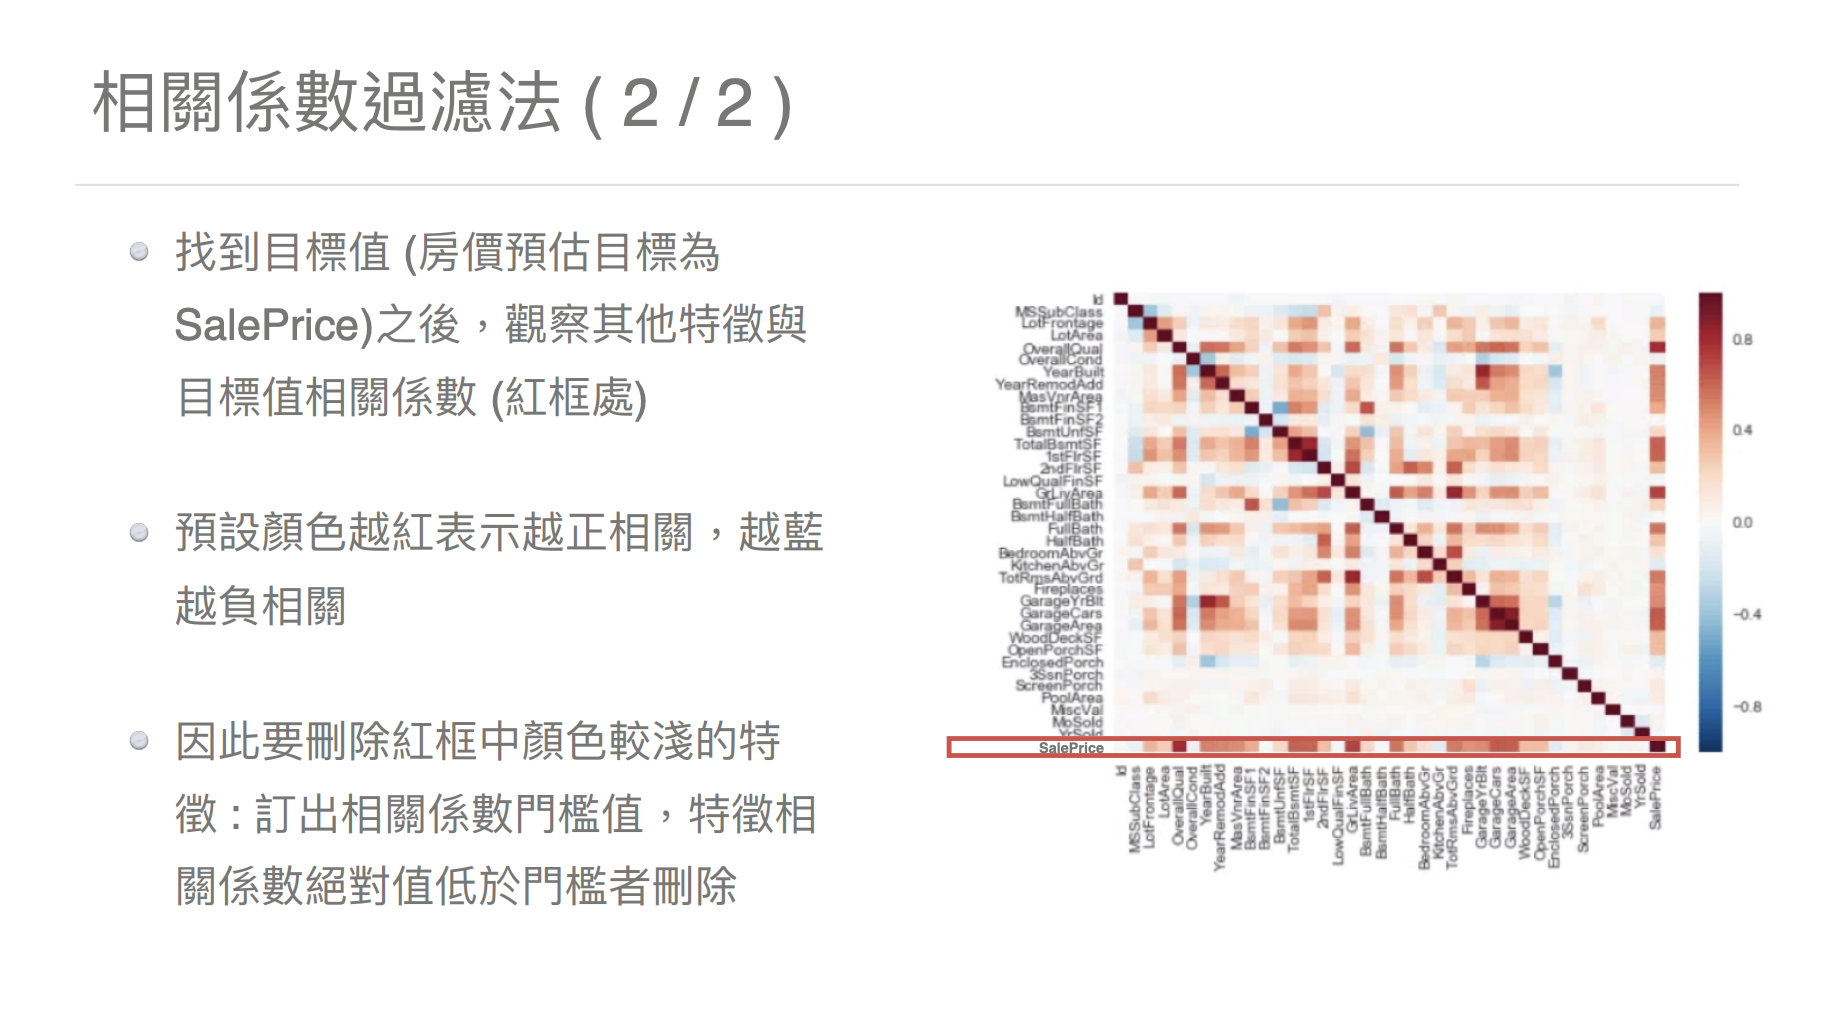

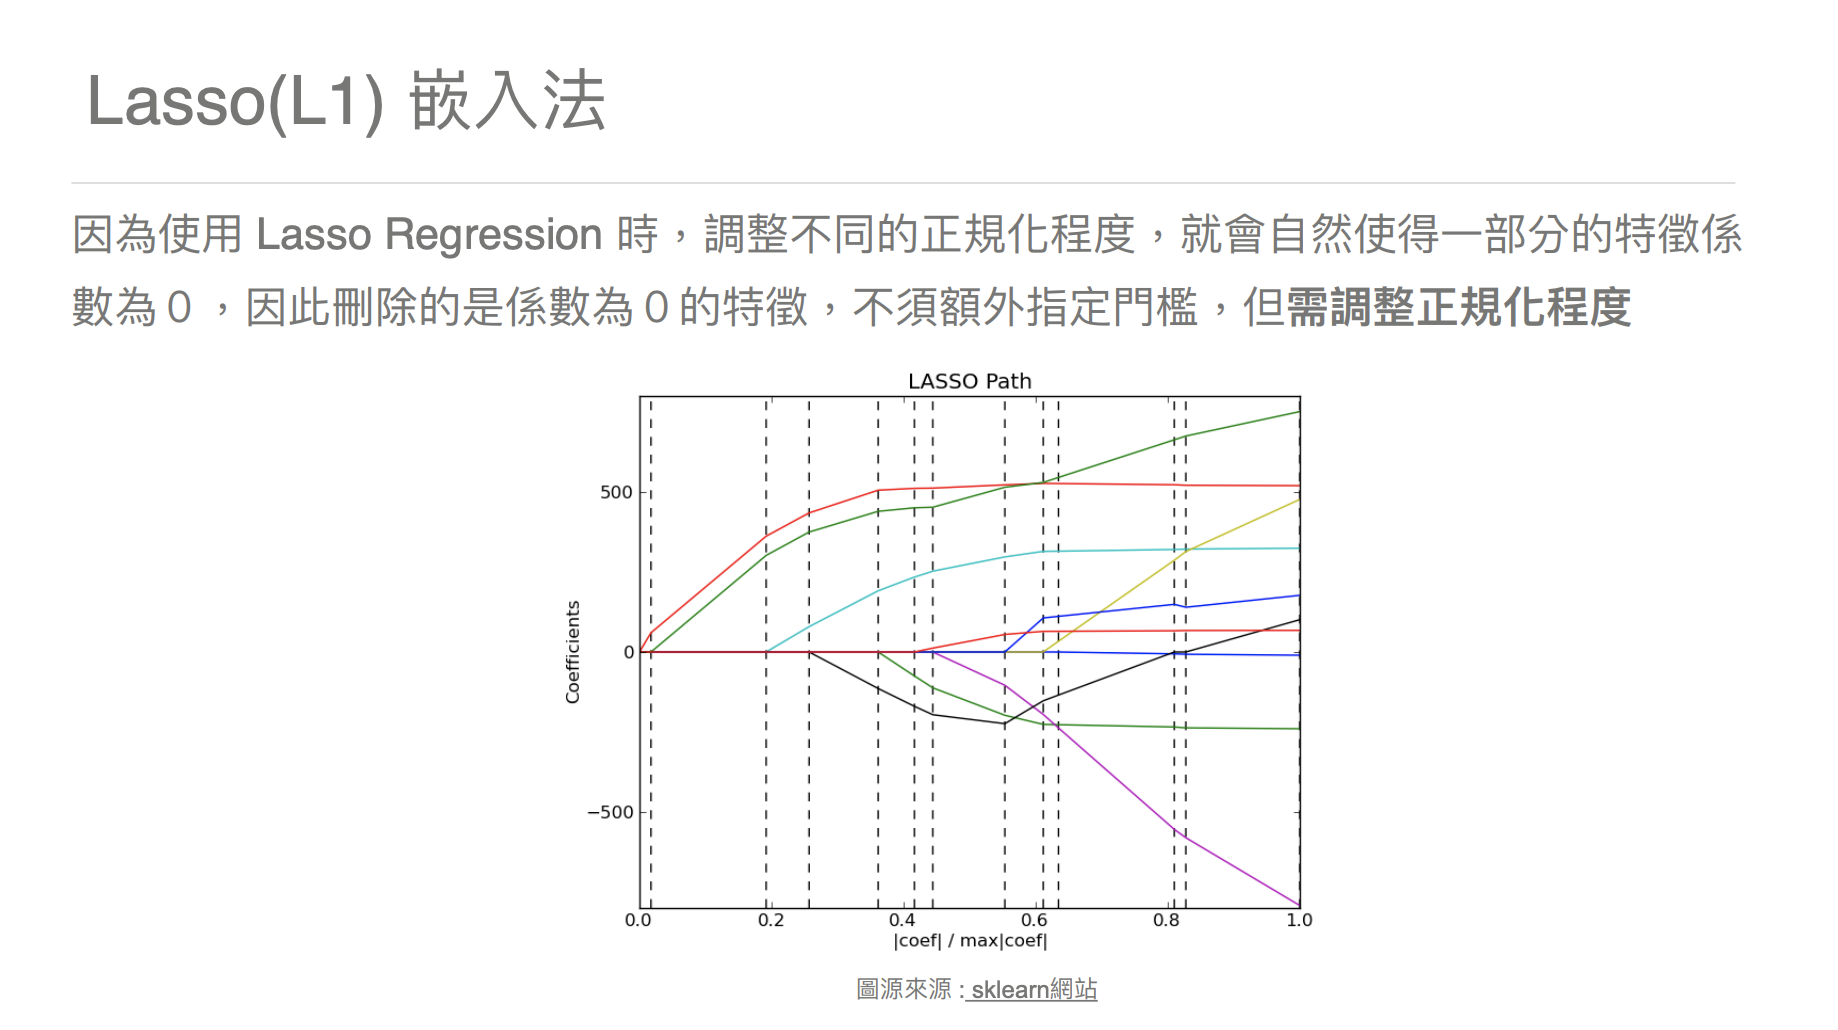

In [ ]:
# 底下是 F.S. - Lasso嵌入的註解筆記，但希望有code的顏色所以沒列markdown

In [ ]:
# Feature Selection -  3.嵌入法 - Lasso嵌入

from sklearn.linear_model import Lasso
# adjust lambda(調整正規化程度) s.t. 部分特徵係數變為0，以降低模型複雜度，就有懲罰項的效果
L1_Reg = Lasso(alpha=0.0001)
# MMEncoder fit_transform(df) to get training set
train_X = MMEncoder.fit_transform(df)
# train model (Lasso) -- 這是用來幫助特徵選擇而做的model，並不是最後建模要預測用的model
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

# 挑掉特徵係數變為0的「無用」column，以降低模型複雜度
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(df), list(L1_mask)))
L1_list

# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list]) # fit_transform(df[L1_list]) --> 只用特徵選擇出來的優秀欄位來建模的意思呀
estimator = LinearRegression() # 這才是最後建模要預測用的model
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

-----

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

data_path = '/Users/johnsonhuang/py_ds/ML_100/2nd-ML100Days/homework/data/Part02/'
df = pd.read_csv(data_path + 'house_train.csv.gz')

train_Y = np.log1p(df['SalePrice'])
df = df.drop(['Id'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr()
sns.heatmap(corr)
plt.show()

<Figure size 640x480 with 2 Axes>

In [3]:
# 記得刪除 SalePrice
df = df.drop(['SalePrice'] , axis=1)

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
df.head()

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


In [4]:
# 篩選相關係數大於 0.1 或小於 -0.1 的特徵
high_list = list(corr[(corr['SalePrice']>0.1) | (corr['SalePrice']<-0.1)].index)
high_list.pop(-1)
print(high_list)

['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']


In [5]:
# 原始特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8444371990086037

In [6]:
# 高相關性特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8288821541594242

In [7]:
# 原始特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df)
estimator = GradientBoostingRegressor()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8874773987145369

In [8]:
# 高相關性特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.872915488713803

In [9]:
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=0.001)
train_X = MMEncoder.fit_transform(df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

array([-0.12408194, -0.        ,  0.        ,  0.81411198,  0.2970946 ,
        0.33007182,  0.08851589,  0.        ,  0.04287006,  0.        ,
       -0.        ,  0.17513694,  0.11086056,  0.        , -0.        ,
        0.87326328,  0.2040765 ,  0.        ,  0.10285172,  0.03174629,
        0.        , -0.        ,  0.12246045,  0.17953898,  0.01851559,
        0.27672243,  0.03230955,  0.09061659,  0.        ,  0.        ,
        0.        ,  0.09550047, -0.        , -0.        ,  0.        ,
       -0.01874705])

In [10]:
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
df.columns[L1_mask]

Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'ScreenPorch', 'YrSold'],
      dtype='object')

In [11]:
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(df), list(L1_mask)))
L1_list

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'ScreenPorch',
 'YrSold']

In [12]:
# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list])
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8475901403725674

In [13]:
# L1_Embedding 特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df[L1_list])
estimator = GradientBoostingRegressor()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8838760064865989

## 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

## [作業目標]

試著調整特徵篩選的門檻值, 觀察會有什麼影響效果

## [作業重點]

調整相關係數過濾法的篩選門檻, 看看篩選結果的影響 (In[5]~In[8], Out[5]~Out[8])

調整L1 嵌入法篩選門檻, 看看篩選結果的影響 (In[9]~In[11], Out[9]~Out[11])

In [14]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

data_path = '/Users/johnsonhuang/py_ds/ML_100/2nd-ML100Days/homework/data/Part02/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId'] , axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


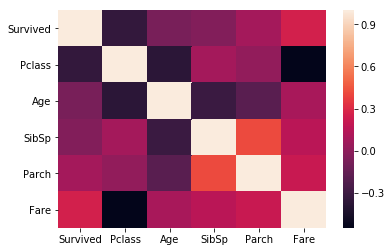

In [15]:
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr()
sns.heatmap(corr)
plt.show()

In [16]:
# 記得刪除 Survived
df = df.drop(['Survived'] , axis=1)

# 只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
df.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


## 作業1

鐵達尼生存率預測中，試著變更兩種以上的相關係數門檻值，觀察預測能力是否提升?

In [17]:
corr

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [18]:
# 原始特徵 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df)
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7038635542329971

In [19]:
# 篩選相關係數1
high_list = list(corr[abs(corr['Survived'] > 0.1)].index)
print(high_list)
high_list.pop(0)
high_list

['Survived', 'Fare']


['Fare']

In [20]:
# 特徵1 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6431067311112506

In [21]:
# 篩選相關係數2
"""
Your Code Here
"""
high_list = list(corr[abs(corr['Survived'] > 0.05)].index)
print(high_list)
high_list.pop(0)
high_list

['Survived', 'Parch', 'Fare']


['Parch', 'Fare']

In [22]:
# 特徵2 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6397484987341242

## 作業2

續上題，使用 L1 Embedding 做特徵選擇(自訂門檻)，觀察預測能力是否提升?

In [23]:
from sklearn.linear_model import Lasso
"""
Your Code Here, select parameter alpha 
"""

L1_Reg = Lasso(alpha=0.0001) # 挑一個更小的 Lasso alpha

train_X = MMEncoder.fit_transform(df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

array([-0.3896642 , -0.28391634, -0.29209741,  0.35235936,  0.40572276])

In [24]:
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(df), list(L1_mask)))
L1_list

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [25]:
# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7038635542329971

In [26]:
from sklearn.linear_model import Lasso
"""
Your Code Here, select parameter alpha 
"""

L1_Reg = Lasso(alpha=0.01) # 挑一個更大的 Lasso alpha

train_X = MMEncoder.fit_transform(df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

array([-0.33670344, -0.        , -0.        ,  0.        ,  0.        ])

In [27]:
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(df), list(L1_mask)))
L1_list

['Pclass']

In [29]:
# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6791567235397566

## 參考資料

## [特徵選擇](https://zhuanlan.zhihu.com/p/32749489)

特徵選擇這一知識因為在統計時代就存在，因此教學文獻就比較多了，因此我們在這邊挑選的反而是比較精簡的說明，同學可以在網頁的內容中，了解過濾法/包裝法/嵌入法三類方法更清楚的說明。

下列是特徵選擇的基礎流程，但因為執行起來很費時，因此也需要領域知識輔助，所以關鍵還是在領域知識。

![img](https://lh5.googleusercontent.com/TWCZF-UzbV2xNAyYzac4gC03mY2WTRor7l6iGmGn8ae05_WS5ON7CRiGWR1svHLBXjwCubqt4QL0X9QJ7s8_sTNk91-xzOa6e2BNeBu232ybog4gAH5tKcmQYSi3s3dqz89aOQooRpQ?t=1557734143418)


### - 文摘

3、嵌入（Embedded）特征选择

### - 基于惩罚项的特征选择法

通过L1正则项来选择特征：L1正则方法具有「稀疏解」的特性，因此天然具备特征选择的特性，

### 但是要注意，L1没有选到的特征不代表不重要，原因是两个具有高相关性的特征可能只保留了一个，如果要确定哪个特征重要应再通过L2正则方法交叉检验。


- 基于学习模型的特征排序

这种方法的思路是直接使用你要用的机器学习算法，针对每个单独的特征和响应变量建立预测模型。

假如某个特征和响应变量之间的关系是非线性的，可以用基于树的方法（决策树、随机森林）、或者扩展的线性模型等。

基于树的方法比较易于使用，因为他们对非线性关系的建模比较好，并且不需要太多的调试。

但要注意过拟合问题，因此树的深度最好不要太大，再就是运用交叉验证。通过这种训练对特征进行打分获得相关性后再训练最终模型。

## [特徵選擇線上手冊](https://machine-learning-python.kspax.io/intro-1)
machine-learning-python 

對比上一參考資料的精簡，這一份手冊的說明就比較完整 : 有各式各樣的特徵選擇方式，建議同學有需要時再來查詢即可。

![img](https://ai100-fileentity.cupoy.com/2nd/homework/D28/1557734177124/large)